## Import Libraries

In [1]:
working_dir = "../."
dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/clinical_eval/dataset.h5"
hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/clinical_eval/hospitals-patients-dict.pkl"
# dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
# hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import pickle
import sys
import timm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from kornia import tensor_to_image
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

sys.path.append(working_dir)
from data_setup import HDF5Dataset, FrameTargetDataset, DataAugmentation

os.chdir(working_dir)
os.getcwd()



'/Users/andry/Documents/GitHub/lus-dl-framework'

In [3]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.0


In [4]:
# Training settings
batch_size = 4
epochs = 20
lr = 1e-4
gamma = 0.7
seed = 21
train_ratio = 0.7

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
mps_device = torch.device('mps')
mps_device

device(type='mps')

## Load Data

In [23]:
dataset = HDF5Dataset(dataset_h5_path)

train_indices_path = os.path.dirname(dataset_h5_path) + f"/train_indices_{train_ratio}.pkl"
test_indices_path = os.path.dirname(dataset_h5_path) + f"/test_indices_{train_ratio}.pkl"

Serialized frame index map FOUND.

Loaded serialized data.


60 videos (14545 frames) loaded.


In [8]:
if os.path.exists(train_indices_path) and os.path.exists(test_indices_path):
    print("Loading pickled indices")
    with open(train_indices_path, 'rb') as train_pickle_file:
        train_indices = pickle.load(train_pickle_file)
    with open(test_indices_path, 'rb') as test_pickle_file:
        test_indices = pickle.load(test_pickle_file)
    # Create training and test subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)  
else:
    train_subset, test_subset, split_info, train_indices, test_indices = dataset.split_dataset(hospitaldict_path, 
                                                              seed, 
                                                              train_ratio)
    print("Pickling sets...")
    
    # Pickle the indices
    with open(train_indices_path, 'wb') as train_pickle_file:
        pickle.dump(train_indices, train_pickle_file)
    with open(test_indices_path, 'wb') as test_pickle_file:
        pickle.dump(test_indices, test_pickle_file)

Loading pickled indices


In [9]:
# test_subset_size = train_ratio/2
# test_subset = Subset(test_subset, range(int(test_subset_size * len(test_indices))))
# test_subset

In [10]:
train_dataset = FrameTargetDataset(train_subset)
test_dataset = FrameTargetDataset(test_subset)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 8930
Test size: 5615


## Image Augmentation

In [11]:
size = (224, 224)
train_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


In [12]:
transform = DataAugmentation()

# train_dataset.set_transform(preprocess)
# test_dataset.set_transform(preprocess)

## Load Datasets

In [13]:
def collate_fn(examples):
    frames = torch.stack([example[0] for example in examples])  # Extract the preprocessed frames
    scores = torch.tensor([example[1] for example in examples])  # Extract the scores
    # return {"pixel_values": frames, "labels": scores}
    return (frames, scores)


In [14]:
train_dataloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=0,
                          pin_memory=True,
                          collate_fn=collate_fn, shuffle=False)

test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          pin_memory=True,
                          collate_fn=collate_fn)

In [17]:
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.1730, 0.1806, 0.1890]) tensor([0.1893, 0.1956, 0.2065])


In [18]:
images, lebels = next(iter(train_dataloader))

In [22]:
images.size()

torch.Size([4, 3, 1055, 672])

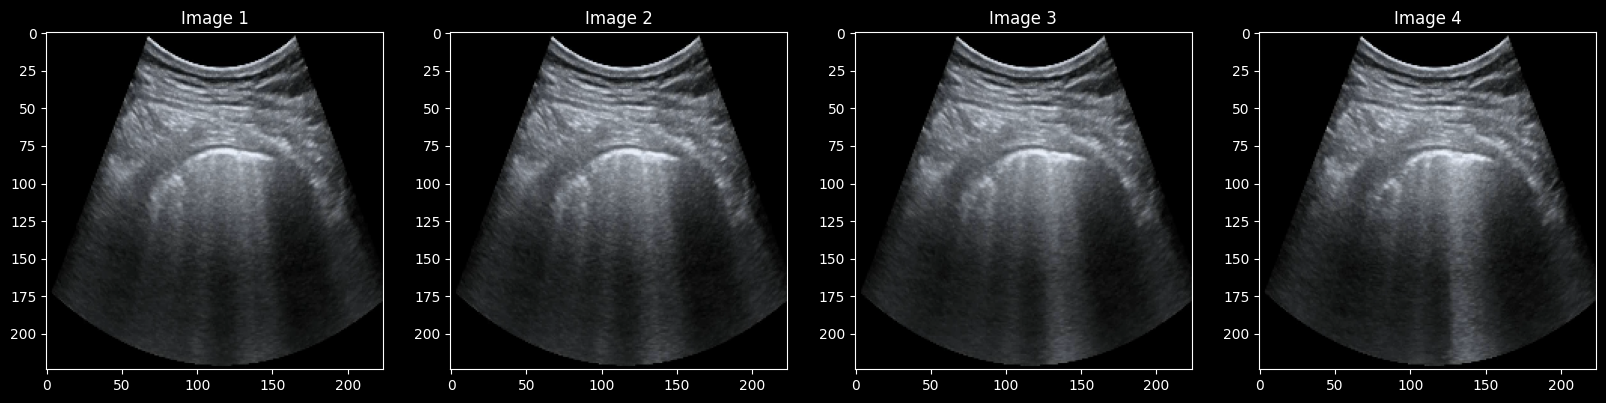

In [38]:
import matplotlib.pyplot as plt
import torchvision

def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(train_dataloader, batch_idx=6)


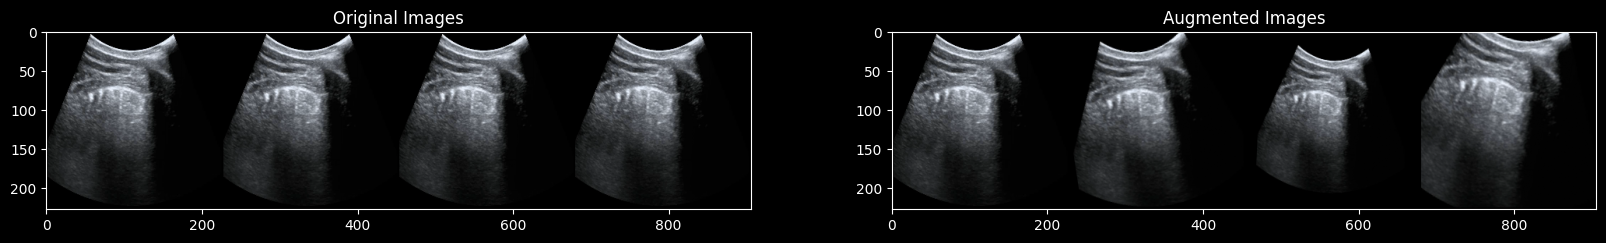

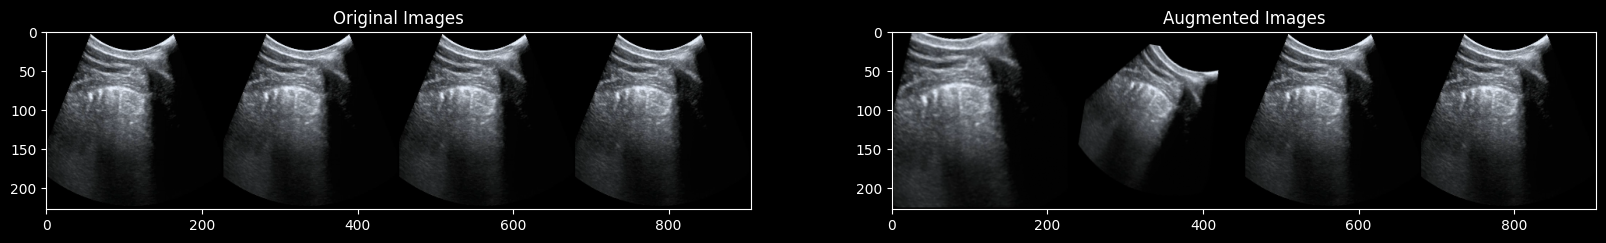

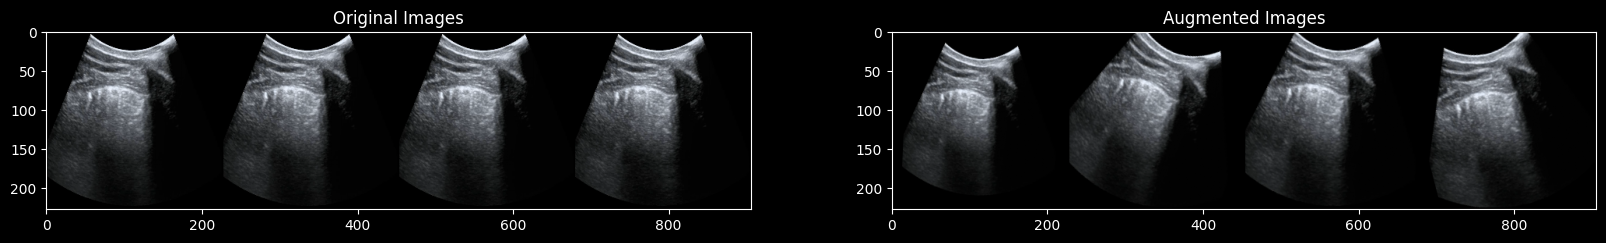

In [39]:

def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(test_dataloader, num_batches=3)

In [81]:
print(len(train_dataset), len(train_dataloader))

8856 554


In [82]:
print(len(test_dataset), len(test_dataloader))

5006 313


# Model

In [83]:
timm.list_models('resnet*',pretrained=True)

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k',
 'resnet34.tv_in1k',
 'resnet34d.ra2_in1k',
 'resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 '

In [84]:
beit = timm.create_model('beit_base_patch16_224.in22k_ft_in22k', 
                         pretrained=True, 
                         num_classes=4)



[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
resnet = timm.create_model('resnet18.a3_in1k', 
                         pretrained=True, 
                         num_classes=4)

In [ ]:
model = resnet

### Training

In [ ]:
model.to(mps_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(beit.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(mps_device)
        label = label.to(mps_device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_dataloader:
            data = data.to(mps_device)
            label = label.to(mps_device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_dataloader)
            epoch_val_loss += val_loss / len(test_dataloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/554 [00:00<?, ?it/s]

/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch : 1 - loss : 1.3752 - acc: 0.2781 - val_loss : 1.3782 - val_acc: 0.2837



  0%|          | 0/554 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.3752 - acc: 0.2781 - val_loss : 1.3782 - val_acc: 0.2837



  0%|          | 0/554 [00:00<?, ?it/s]

KeyboardInterrupt: 